In [1]:
using JuMP, Plots, Ipopt

In [2]:
# specific parameters for each model 
P1 = 50
P2 = 50
P3 = 50
P4 = 50
P =  P1 + P2 + P3 + P4 

N = 4   # number of trailers
M = 4   # M number of constrained trailers
w = 0.8  # current

if N ≥ 2
    l = 1/ N # length of trailers  
else
    l = 1/sqrt(N)
end

ϵ = 1e-2;

0.01

In [3]:
#JuMP model, Ipopt solver
sys = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level"=> 5))
set_optimizer_attribute(sys,"tol",1e-14)
set_optimizer_attribute(sys,"max_iter",1000)

# initial data
x0 = 0 
y0 = 0 
θ0 = pi/7 

# final data
xf = 4
yf = 7
θf = 3*π/2 

JuMP.@variables(sys,begin
    x[1:P]                          # x 
    y[1:P]                          # y 
    θ[1:P]                       # theta 
    0 ≤ Δt_1 ≤ 1 
    0 ≤ Δt_2 ≤ 1
    0 ≤ Δt_3 ≤ 1
    0 ≤ Δt_4 ≤ 1

    end) 

JuMP.@variable(sys, betas[1:P, 1:N])

#Objective

@objective(sys,Min, Δt_1*P1 +Δt_2*P2+ Δt_3*P3+Δt_4*P4)


#Constraints

u=transpose([1 0 1 0])

@constraints(sys,begin
    x[1] == x0
    y[1] == y0
    θ[1] == θ0

    x[P] == xf
    y[P] == yf
    θ[P] == θf
    end)

@constraint(sys,c1[j=1:N],
     betas[1,j]==0)

# final constraint for the sum of betas(tf) 
sum_ = 0
for i in 1 : M
    sum_ += betas[P,i]^2 
end
@constraint(sys, sum_ ≤ ϵ^2 )

# constraints for betas
for i in 1:N
    s = sum(asin(l/sqrt(1-(k-1)*l^2)) for k in 1:i) 
    for j in 1:P
        @constraint(sys, -s ≤betas[j,i]≤ s)
    end
end

In [4]:
for j in 1 : P1-1
    @NLconstraint(sys, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt_1 * (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt_1 *(sin(θ[j])+ sin(θ[j+1])))
    if N ≥ 1  
        @NLconstraint(sys, #beta1 ' = -u- 1/l * sin(beta1)
            betas[j+1,1] == betas[j,1] + 0.5 * Δt_1 * (-u[1]-(1/l)*sin(betas[j,1]) - u[1] - (1/l)*sin(betas[j+1,1]))) 
    end
    if N ≥ 2  
        @NLconstraint(sys, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
            betas[j+1,2] == betas[j,2] + 0.5 *  Δt_1 * (-u[1] - cos(betas[j,1])*sin(betas[j,2] - betas[j,1])/l - u[1] - cos(betas[j+1,1])*sin(betas[j+1,2] - betas[j+1,1])/l ))   
    end
    if N ≥ 3 
        for i in 3 : N 
            prod1 = @NLexpression(sys,prod(cos(betas[j,p]-betas[j,p-1]) for p in 2 : i-1 )*sin(betas[j,i]-betas[j,i-1])*cos(betas[j,1]) )
            prod2 = @NLexpression(sys,prod(cos(betas[j+1,p]-betas[j+1,p-1]) for p in 2 : i-1 )*sin(betas[j+1,i]-betas[j+1,i-1])*cos(betas[j+1,1]) )  
            @NLconstraint(sys, #betas for i = 3 to N
                betas[j+1,i] == betas[j,i]+ 0.5*Δt_1*(-u[1]-prod1/l -u[1] -prod2/l ) ) 
        end
    end        
end
    @NLconstraint(sys,[j = 1:(P1-1)],  # theta ' = u 
        θ[j+1] == θ[j] + 0.5 *Δt_1*(u[1]+ u[1]) )




for j in P1 : P1+P2-1
    @NLconstraint(sys, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt_2 * (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt_2 *(sin(θ[j])+ sin(θ[j+1])))
    if N ≥ 1  
        @NLconstraint(sys, #beta1 ' = -u- 1/l * sin(beta1)
            betas[j+1,1] == betas[j,1] + 0.5 * Δt_2 * (-u[2]-(1/l)*sin(betas[j,1]) - u[2] - (1/l)*sin(betas[j+1,1]))) 
    end
    if N ≥ 2  
        @NLconstraint(sys, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
            betas[j+1,2] == betas[j,2] + 0.5 *  Δt_2 * (-u[2] - cos(betas[j,1])*sin(betas[j,2] - betas[j,1])/l - u[2] - cos(betas[j+1,1])*sin(betas[j+1,2] - betas[j+1,1])/l ))   
    end
    if N ≥ 3 
        for i in 3 : N 
            prod1 = @NLexpression(sys,prod(cos(betas[j,p]-betas[j,p-1]) for p in 2 : i-1 )*sin(betas[j,i]-betas[j,i-1])*cos(betas[j,1]) )
            prod2 = @NLexpression(sys,prod(cos(betas[j+1,p]-betas[j+1,p-1]) for p in 2 : i-1 )*sin(betas[j+1,i]-betas[j+1,i-1])*cos(betas[j+1,1]) )  
            @NLconstraint(sys, #betas for i = 3 to N
                betas[j+1,i] == betas[j,i]+ 0.5*Δt_2*(-u[2]-prod1/l -u[2] -prod2/l ) ) 
        end
    end        
end
    @NLconstraint(sys,[j = P1:(P1+P2-1)],  # theta ' = u 
        θ[j+1] == θ[j] + 0.5 *Δt_2*(u[2]+ u[2]) )



for j in P1+P2 : P1+P2+P3-1
    @NLconstraint(sys, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt_3 * (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt_3 *(sin(θ[j])+ sin(θ[j+1])))
    if N ≥ 1  
        @NLconstraint(sys, #beta1 ' = -u- 1/l * sin(beta1)
            betas[j+1,1] == betas[j,1] + 0.5 * Δt_3 * (-u[3]-(1/l)*sin(betas[j,1]) - u[3] - (1/l)*sin(betas[j+1,1]))) 
    end
    if N ≥ 2  
        @NLconstraint(sys, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
            betas[j+1,2] == betas[j,2] + 0.5 *  Δt_3 * (-u[3] - cos(betas[j,1])*sin(betas[j,2] - betas[j,1])/l - u[3] - cos(betas[j+1,1])*sin(betas[j+1,2] - betas[j+1,1])/l ))   
    end
    if N ≥ 3 
        for i in 3 : N 
            prod1 = @NLexpression(sys,prod(cos(betas[j,p]-betas[j,p-1]) for p in 2 : i-1 )*sin(betas[j,i]-betas[j,i-1])*cos(betas[j,1]) )
            prod2 = @NLexpression(sys,prod(cos(betas[j+1,p]-betas[j+1,p-1]) for p in 2 : i-1 )*sin(betas[j+1,i]-betas[j+1,i-1])*cos(betas[j+1,1]) )  
            @NLconstraint(sys, #betas for i = 3 to N
                betas[j+1,i] == betas[j,i]+ 0.5*Δt_3*(-u[3]-prod1/l -u[3] -prod2/l ) ) 
        end
    end        
end
    @NLconstraint(sys,[j = P1+P2:(P1+P2+P3-1)],  # theta ' = u 
        θ[j+1] == θ[j] + 0.5 *Δt_3*(u[3]+ u[3]) )



for j in P1+P2+P3 : P-1
    @NLconstraint(sys, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt_4 * (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt_4 *(sin(θ[j])+ sin(θ[j+1])))
    if N ≥ 1  
        @NLconstraint(sys, #beta1 ' = -u- 1/l * sin(beta1)
            betas[j+1,1] == betas[j,1] + 0.5 * Δt_4 * (-u[4]-(1/l)*sin(betas[j,1]) - u[4] - (1/l)*sin(betas[j+1,1]))) 
    end
    if N ≥ 2  
        @NLconstraint(sys, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
            betas[j+1,2] == betas[j,2] + 0.5 *  Δt_4 * (-u[4] - cos(betas[j,1])*sin(betas[j,2] - betas[j,1])/l - u[4] - cos(betas[j+1,1])*sin(betas[j+1,2] - betas[j+1,1])/l ))   
    end
    if N ≥ 3 
        for i in 3 : N 
            prod1 = @NLexpression(sys,prod(cos(betas[j,p]-betas[j,p-1]) for p in 2 : i-1 )*sin(betas[j,i]-betas[j,i-1])*cos(betas[j,1]) )
            prod2 = @NLexpression(sys,prod(cos(betas[j+1,p]-betas[j+1,p-1]) for p in 2 : i-1 )*sin(betas[j+1,i]-betas[j+1,i-1])*cos(betas[j+1,1]) )  
            @NLconstraint(sys, #betas for i = 3 to N
                betas[j+1,i] == betas[j,i]+ 0.5*Δt_4*(-u[4]-prod1/l -u[4] -prod2/l ) ) 
        end
    end        
end
    @NLconstraint(sys,[j = P1+P2+P3:(P-1)],  # theta ' = u 
        θ[j+1] == θ[j] + 0.5 *Δt_4*(u[4]+ u[4]) )


println("Solving...")
status = optimize!(sys)
println("Solver status : ",status)
println("Cost : " , objective_value(sys))

println("t1 = ",value.(Δt_1*P1))
println("t2 = ",value.(Δt_1*P1+Δt_2*P2))
println("t3 = ",value.(Δt_1*P1+Δt_2*P2+Δt_3*P3))
println("tf = ", value.(Δt_1*P1+Δt_2*P2+Δt_3*P3+Δt_4*P4))

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     7373
Number of nonzeros in inequality constraint Jacobian.:     1604
Number of nonzeros in Lagrangian Hessian.............:    21098

Total number of variables............................:     1404
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1403
Total number of in

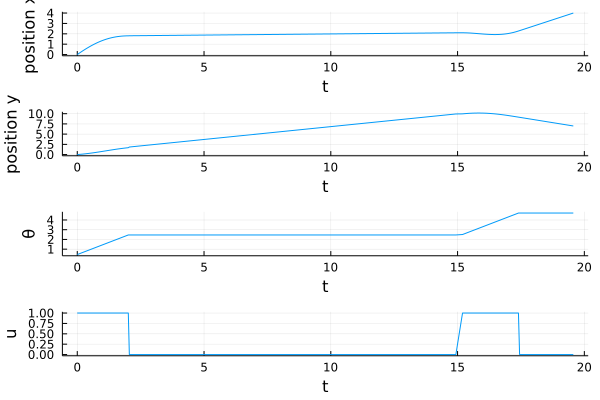

In [5]:
x1 = value.(x)
y1 = value.(y)
θ1 = value.(θ)
betas1 = value.(betas)
u1 = transpose([ones(1,P1) zeros(1,P2) +ones(1,P3) zeros(1,P4)])

#plots : states 

t1 = value.(Δt_1)*P1
t2 = value.(Δt_2)*P2
t3 = value.(Δt_3)*P3
t4 = value.(Δt_4)*P4

vec1 = value.(Δt_1)*(0:P1-1)
vec2 = value.(Δt_2)*(0:P2-1)+ t1*ones(P2)
vec3 = value.(Δt_3)*(0:P3-1)+(t1+t2)*ones(P3)
vec4 = value.(Δt_4)*(0:P4-1)+(t1+t2+t3)*ones(P4)

t = vcat(vec1,vec2,vec3,vec4) 

x_plot = plot(t,x1,xlabel = "t", ylabel = "position x", legend = false)
y_plot = plot(t,y1,xlabel = "t", ylabel = "position y", legend = false)
θ_plot = plot(t,θ1,xlabel = "t", ylabel = "θ", legend = false)
u_plot = plot(t,u1,xlabel = "t", ylabel = "u", legend = false)
display(plot(x_plot,y_plot,θ_plot,u_plot,layout = (2,2), size=(600, 600)))

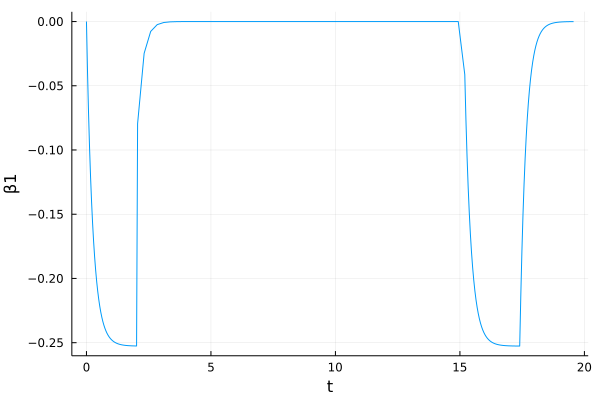

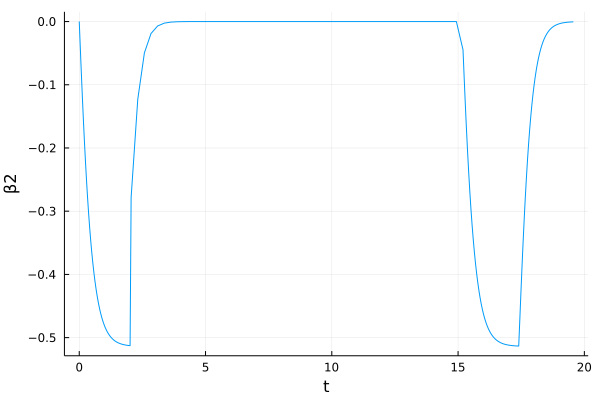

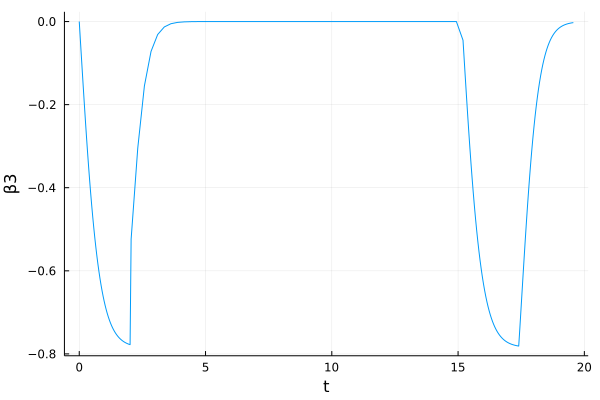

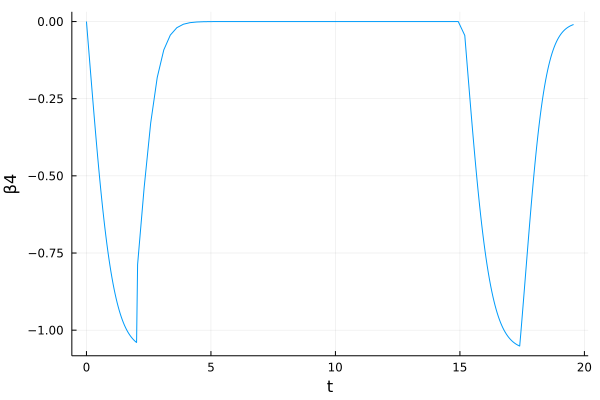

In [6]:
for i in 1:N # if N = 0 , there is no plot 
    name = "β" * string(i)
    display(plot(t, betas1[:,i], xlabel ="t", ylabel=name, legend =false, layout =(1,1), size=(400, 400)))   
end

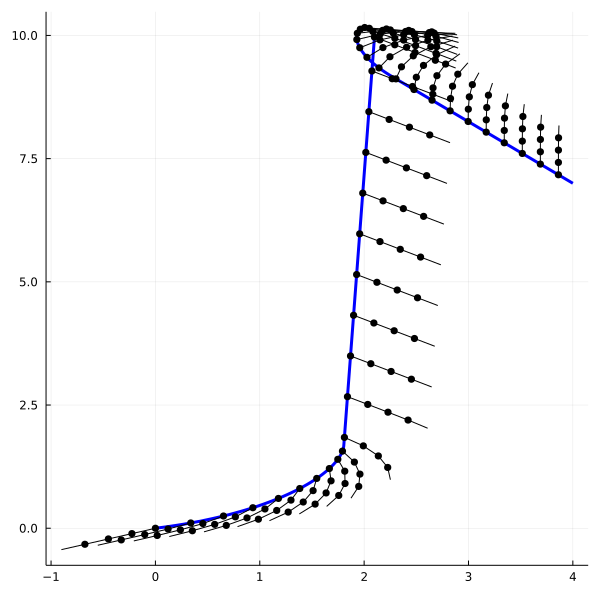

In [7]:
#plot: trajectory 

p = plot(x1,y1,legend = false,c = :blue,lw = 3)
plot!(size=(2000,2000))

for j = 1 : 5 : P
    betas_z = zeros(2,N+1)       # storage of z_i = z_{i-1}-l*[cos(theta_{i-1}) sin(theta_{i-1})] 
    betas_z[1,1] = x1[j]
    betas_z[2,1] = y1[j]
    θ_p = θ1[j]
    
    β_v = zeros(N)
    θ_v = zeros(N)

    for i in 2:N+1
        
        β_v[i-1]= betas1[j,i-1]
        θ_v[i-1] = β_v[i-1] + θ_p
        betas_z[1,i] = betas_z[1,i-1] - l*cos(θ_v[i-1])
        betas_z[2,i] = betas_z[2,i-1] - l*sin(θ_v[i-1])
        plot!([betas_z[1,i-1], betas_z[1,i]],[betas_z[2,i-1], betas_z[2,i]], color = :black,legend = false )
        plot!([betas_z[1,i-1]],[betas_z[2,i-1]],seriestype = :scatter,color = :black, legend = false)
        plot!(size=(600,600))
    end
end
current()